# Part 1 - Getting Comfy with Spatial Data

**ETA** : 45min<br>
**Main Topics** :
1. Visualization of Spatial Transcriptomics data
2. Expression-based clustering
3. Differential Gene Expression (DGE) Analysis
3. Factor Analysis by Latent Dirichlet Allocation


**Information**:<br>
This part is designed with the intention to let you familiarize yourself with spatial data. As you see from the main topics, we will go through some relatively basic concepts. I'm not really expecting this first part to blow your minds, but rather to let you explore the data and relate it to your previous experiences while simultaneously put the analysis we will be performing in Part 2 and 3 into some context.<br>
<br>
Before continuing it's appropriate to make a minor disclaimer, being that we will exclusively will work with data originating from the 10X Visium platform. Let me just emphasize that several other spatial transcriptomics techniques exists and can be more or less appropriate to use depending on your research question. The aim with this session is not to convince you that Visium is superior to the other techniques - it's not, nor is it inferior - but to expose you to *one type* of spatial data and (fingers crossed) get you excited by this rapidly growing field.
<br><br>
Some suites or packages have introduced support for spatial data (e.g., [Seurat][2], [STUtility][4] and [scanpy][3]), and more alternatives will likely come. However, I have intentionally chosen to not work with any of these but rather rely on common Python libraries to conduct the necessary analysis. There are two main reasons for this:
<br>
1. **Reduction of Abstraction** - while usually efficient and easy to operate, the aforementioned suites tend to introduce multiple layers of abstraction into the analysis, distancing the user from the actual process. I'd like to avoid this as much as possible.
<br>
2. **Flexibility** - My hope is that if you get familiar with the means by which the analysis is conducted, you will be able to transfer that knowledge and understanding to whatever language, suite or experimental platform that you prefer to work with.
<br>

**Notation**:
The notebook is constructed with the ambition to make the steps very transparent, as a result there is quite a lot of code being exposed. For those of you who want to devote minimal time to code interpretation and prefer to focus on concepts and results; cells with code that is not essential to understand in order to follow the workflow have the indicator:<br>
```python
#------NON-CONCEPTUAL------#

```
and you may execute them without paying too much attention to the content

**Data**:
We will be using Human Breast Cancer (Visium Data), accessible at 10X Genomics [website][1], throughout the analysis.

[1]: [https://support.10xgenomics.com/spatial-gene-expression/datasets]
[2]: [https://satijalab.org/seurat/]
[3]: [https://icb-scanpy.readthedocs-hosted.com/en/stable/]
[4]: [https://ludvigla.github.io/STUtility_web_site/]

In [24]:
#------NON-CONCEPTUAL------#
# begin by loading the different packages that we will be using

import anndata as ad
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from typing import Tuple,Union, List

from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

In [25]:
# load data; we will begin with just one sample for the sake of convenience 
data_pths = dict(sample_1 = "../data/bc/curated/bc-A1.h5ad") 
data = ad.read_h5ad(data_pths["sample_1"])

In [26]:
# let us inspect the data that we just loaded 
display(data)

AnnData object with n_obs × n_vars = 3813 × 33514
    obs: 'barcodes', 'under_tissue', '_x', '_y', 'x', 'y'
    var: 'name', 'id', 'n_counts'
    uns: 'fiducial_diameter_fullres', 'image_hires', 'spot_diameter_fullres', 'tissue_hires_scalef'

## Data Format
As of now there is no officially accepted format for storage of spatial data, thus
what you see is a highly personal construction. As you may
notice it is built around the AnnData object, designed specifically with
large scale biological data in mind. Some links that might be of interest are:

* documentation of this format : https://github.com/almaan/space2h5ad/
* documentation for anndata : https://anndata.readthedocs.io/en/latest/

The linked github page thoroughly explains the format and what object each
key (e.g., "\_x" and "\_y") relates to, but to briefly summarize those of most
relevancy to us right now:<br>
* _.obs_ : x and y - spatial coordinates, matched to the fullscale image. We will be using resized images (since we only wish to use the images for visualization, there is no point in using $20000\times 20000$ pixel images). Hence these coordinates need to be scaled using a conversion factor. "\_x" and "\_y" are similar, but provides you with the array coordinates (integer numbers)
* _.uns_ : "image_hires" - the HE-image of the tissue, the name "hires" is kept from the spacerange output.
* _.uns_ : "tissue_hires_scalef" - scaling factor mentioned above, multiply coordinates "x" and "y" with this to map to the "hires" image.
* _.var_ : name - contains the ensembl and hgnc gene symbols

**Note**: how the data is stored in the format "n_spots x n_genes" equivalent to "n_observations x n_features". This is opposite (actually transpose) to the convention of the "SingleCellExperiment" class which Seurat uses, which some of you might be more familiar with.

## Visualization

Working with spatial data, visualization becomes an even more integral part of the workflow. We are able to relate the gene expression spatially, and with some methods (like Visium) also matching this to an image of our tissue, this  enhances our ability to assess, validate and evaluate any computational results. For example, when clustering the spatial data, we have the privilege of not only being able to see if the clusters "make sense" in gene expression space (using methods like UMAP), but also whether they check out in the real spatial domain. Thus, we will set aside some extra time to work with visualization specifically.

We will start by defining a function - `plot_data` -  to aid us with the visualization of our data.
This avoids repetitive code and facilitates  a more swift workflow.

I would recommend you to browse through the function, just to get an idea of what is going on. Feel free to modify this, and add any feature you might find useful - but don't overwrite the current methods. I tend to use [type hints][1] when defining my functions, but there if no need for you to adhere to this practice if you prefer not to.


[1]: https://docs.python.org/3/library/typing.html

In [27]:
def plot_data(ax : plt.Axes,
              data : ad.AnnData,
              feature : Tuple[str,str] = None,
              title : str = None,
              plt_args : dict = None,
              show_image : bool = True,
              clean : bool = True,
             )->None:
    
    """ Plot Spatial Data
    
    Parameters:
    ----------
    ax : plt.Axes
        matplotlib axes object to plot in
    data : ad.AnnData
       anndata object containing spatial data
    feature : Tuple[str,str]
        first element the type of feature (e.g., 'name') to be plotted
        second element is variable name (e.g., 'ERBB2')
    title : str
        string containing title of plot
    plt_args : dict
        matplotlib keyword arguments for scatter plot
        to customize the visualization
    show_image : bool
        overlay plot on image
    clean :
        remove spines and tick from plot
    
    """
    
    # get scale factor
    sf = data.uns['tissue_hires_scalef']
    
    # plot image as background
    # if specified
    if show_image:
        ax.imshow(data.uns['image_hires']\
                  .transpose(1,0,2))
    else:
        ax.invert_yaxis()
    
   # default plot settings
    _plt_args = dict(alpha = 0.8,
                     edgecolor = None,
                     marker = 'o',
                     s = 20,
                     cmap = plt.cm.magma,
                    )
    # update plot settings if
    # provided as input
    if plt_args is not None:
        for k,v in plt_args.items():
            _plt_args[k] = v
            
    # set feature values as color
    # values to be plotted
    if feature is not None:
        # locate position of 
        # feature in the data matrix
        pos = np.where(data.var[feature[0]]\
                       .values == feature[1])[0]
        
        # grab feature values
        vals = data.X[:,pos].flatten()
        vals /= vals.max()
        
        # set colorspace
        if plt_args["cmap"] == "feature":
            # if alpha-values should
            # be used to to display
            # signal strength of feature
            rgba = np.zeros((vals.shape[0],4))
            rgba[:,0] = 1
            rgba[:,3] = vals 
            _plt_args["c"] = rgba
            _plt_args["cmap"] = None
            _plt_args["alpha"] = None
        else:
            # if colormap should be
            # used to display signal
            # values
            _plt_args["c"] = vals
            
    
    # generate scatter plot
    # from spot coordinates
    # adjusted to fit image using
    # the scaling factor
    ax.scatter(data.obs['x'] * sf,
               data.obs['y'] * sf,
               **_plt_args,
              )
    
    ax.set_aspect("equal")
    
    # set title if one is provided
    if title is not None:
        ax.set_title(title)
        
    # clean axes if specified
    if clean:
        clean_ax(ax)
            
    return None

def clean_ax(ax : plt.Axes,
             remove_spines : Union[str,List[str]] = "all",
             keep_ticks : bool = False,
            )->None:
    """clean axes
    
    removes ticks and 
    spines from an axes
    object
    
    Parameters:
    ----------
    ax : plt.Axes
        axes object to clean
    
    remove_spines : Union[str,List[str]]
       list of spines to remove. If "all" is
       given, all spines will be removed.
    
    keep_ticks : bool
        set to true if tick should be kept
    
    """
    
    if remove_spines is None:
        remove_spines = []
    elif isinstance(remove_spines,str):
        remove_spines = [remove_spines]
        
    if remove_spines[0] == "all":
        remove_spines = ["left",
                         "top",
                         "right",
                         "bottom"]
    
    if not keep_ticks:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    for sp in remove_spines:
        ax.spines[sp].set_visible(False)
    

Using the function we just created, we will have a look at :

1. The spatial arrangement of the spots
2. The spatial arrangement of the spots overlaid on the HE-image
3. The spatial arrangement of spots with facecolors indicating the expression value of a specific gene (_ERBB2_), overlaid on the HE-image

**Note** : how in (3), instead of using a colormap, we let the alpha-values of the red color be proportional to the observed gene expression; this allows us to inspect the spots without them obscuring the image. You are welcome to use any color for this purpose (just change how the `rgba` variable is defined above), but from experience "red" (in contrast to many other colors) is relatively compatible with the blue/purple color tint of the HE-image.

**Note** : there is one keyword argument called `plt_args` in our function, this allows you to customize the plot graphics, if you are not overtly familiar with matplotlib and it's "plotting-nomenclature" you can find all information regarding compatible arguments for the `scatter` function [here][1].

**Comment** : The gene _ERBB2_ is characteristic of HER2-positive breast cancers, which is the clinical subtype assigned to this sample.

[1]: [https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.scatter.html]

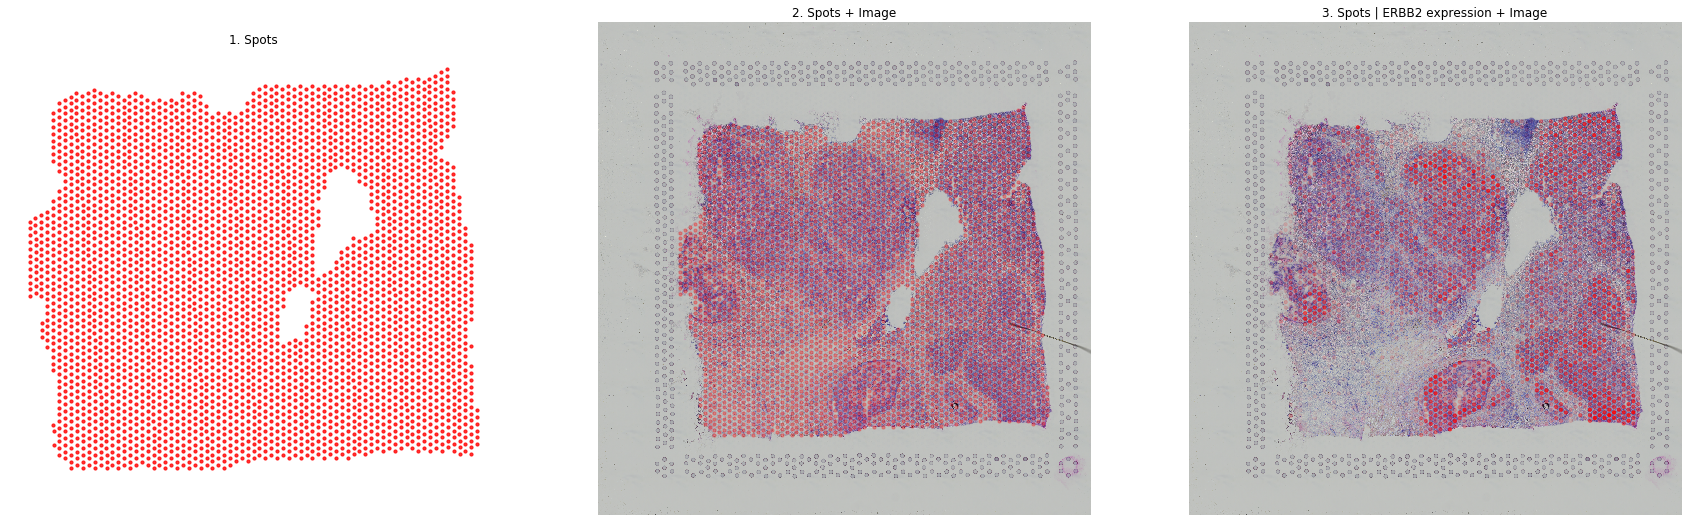

In [86]:
fig, ax = plt.subplots(nrows = 1,
                       ncols = 3,
                       figsize = (30,10))

plot_data(ax[0],
          data,
          title = "1. Spots",
          show_image = False,
          plt_args = {"c":"red","s":10})

plot_data(ax[1],
          data,
          title = "2. Spots + Image",
          show_image = True,
          plt_args = {"alpha":0.3,
                      "c":"red",
                      "s":10})

plot_data(ax[2],
          data,
          title = "3. Spots | ERBB2 expression + Image",
          feature = ["name","ERBB2"],
          show_image = True,
          plt_args = {"alpha":0.5,
                      "s":10,
                      "cmap":"feature"})

To get a feeling for how expression profiles in our data may look, we will extract some of the most variable genes and inspect their spatial distribution. 

Just as when working with single cell data, we usually want to do some quality filtering to remove spurious or irrelevant signals. I will not argue for any "best practice" here, what filtering procedure you should apply is by large dictated by the purpose of your analysis. Here we will apply two basic criteria upon filtering:

1. Genes should be expressed in at least 1% of the spots
2. Genes should have at least 100 UMIs across the whole tissue 

We will define a function `filter_features` which given an AnnData object (like `data`) will return a boolean vector (elements are "False" or "True"), indicating whether the features (genes) fulfill our specified criteria. To clarify, this will not modify our `data` object.

In [29]:
def filter_features(data : ad.AnnData,
                    min_obs : float = 0.01,
                    min_tot : float = 100,
                    verbose : bool = True,
                   ) -> np.ndarray:
    
    """filter features
    
    Parameters:
    ----------
    
    data : ad.AnnData
        anndata object containing spatial data
    min_obs : float
        minimal fraction or number of spots that
        gene should be observed at. If min_obs <1
        it will be intepreted as a fraction.
    min_tot : float
        minimal number of total UMI's
        for a gene
        
    Returns:
    -------
    
    boolean vector of indices to keep
    
    
    """
    
    
    n_spots, n_genes = data.X.shape
    if min_obs < 1:
        adj_min_obs = min_obs*n_spots
    else:
        adj_min_obs = min_obs
        
    keep_1 = data.X.sum(axis = 0) > min_tot
    keep_2 = (data.X > 0).sum(axis=0) > adj_min_obs
    keep = keep_1 * keep_2
    
    if verbose:
        print("Filtering Features with |"\
              " min_obs < {} spots |"\
              " min_tot < {} UMIs".format(adj_min_obs,min_tot))
        print("Kept {}/{} genes".format(keep.sum(),n_genes))

    return keep
    

The next step is to apply the filtering to our data using this function. After this, we will extract the genes with highest variance. The number of top variable genes to extract has been set to 10, but you may change this if you want to - the following steps should be compatible with any number.

In [30]:
# subject data to quality filtering
keep_genes = filter_features(data,
                             min_obs = 0.01,
                             min_tot = 100) 



Filtering Features with | min_obs < 38.13 spots | min_tot < 100 UMIs
Kept 14291/33514 genes


In [87]:
# compute variance of genes that passed
# quality filtering
gene_var = np.var(data.X[:,keep_genes],
                  axis =  0)

# get sorted indices w.r.t. variance
# add [::-1] to sort from hight to low
idx_var_sort = np.argsort(gene_var)[::-1]

# set the number of top variable genes to extract
n_top = 10
# get the names of the top variable genes
top_var_genes= data\
               .var['name']\
               .values[keep_genes][idx_var_sort[0:n_top]]

The top selected variable genes are :

In [88]:
#------NON-CONCEPTUAL------#

# diplay the genes with highest variance and their names
display(pd.DataFrame(dict(Gene = top_var_genes,
                          Variance = gene_var[idx_var_sort][0:n_top]),
                  index =np.arange(10)+1).T)

1        2        3        4        5        6        7   \
Gene      COX6C     IGKC      MGP    IGHG3    IGLC2     KRT8    KRT19   
Variance  68747  63119.6  62050.3  29209.4  17148.5  9412.97  7398.87   

               8        9        10  
Gene       IGFBP5    KRT18      B2M  
Variance  6221.71  3672.24  2997.34

We can inspect how the variance is distributed among the genes by considering variance as a function of the rank, we will also highlight the top ten genes. This allows us to put the numbers above into some context.

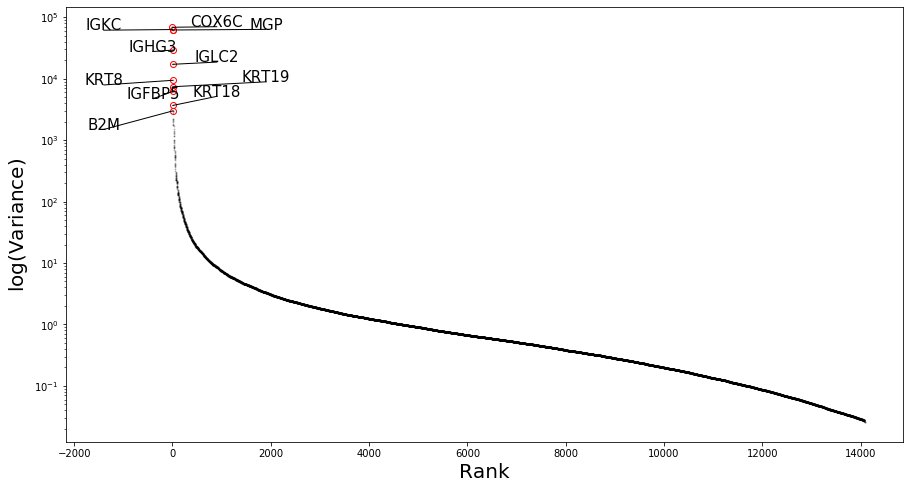

In [89]:
#------NON-CONCEPTUAL------#

fig, ax = plt.subplots(1,
                       1,
                       figsize = (15,8))

ax.plot(gene_var[idx_var_sort],
           marker = '.',
           color = "black",
           linewidth = 0,
           alpha = 0.2,
           markersize = 2,
           )

ax.plot(gene_var[idx_var_sort[0:n_top]],
        markerfacecolor = "none",
        markeredgecolor = "red",
        marker = 'o',
        linewidth = 0,
        )

for rank in range(n_top):
    x = rank
    y = gene_var[idx_var_sort][rank]
    _x = x + ((-1)**rank)*(400 + (((rank+1) % 4)*500))
    _y = y + (-1)**rank*1500 
    ax.text(x = _x,
            y = _y,
            s = "{}".format(top_var_genes[rank]),
            ha ="center",
            fontsize = 15,
           )
    
    ax.plot((x,_x),
            (y,_y),
            '-',
            color ="black",
            linewidth = 1,
           )
    ax.set_xlabel("Rank",fontsize = 20)
    ax.set_ylabel(r"$\log$" + "(Variance)",fontsize =20)
    ax.set_yscale("log")

plt.show()

We see that there is a small set of genes that have a very high variance compared to the rest (notice the log scale on the y-axis). The genes within this set are not homogenously distributed across the tissue and we might expect them to posses some interesting spatial patterns. Visualizing the expression we see that such is indeed the case, there are several different spatial patterns present among these genes.

**Note**: to clarify, when stating that a gene is highly ranked this means it has a low numerical value of it's rank. If confusing, think of it as similar to how one in general speaks of the best athlete in a sport as being ranked first.

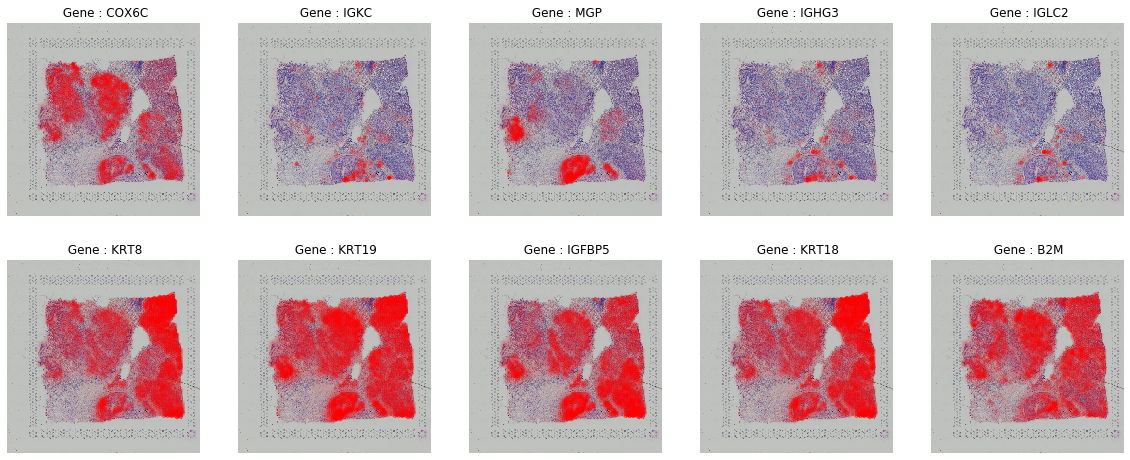

In [90]:
# specify number of columns when displaying plot grid
n_cols = 5
# get number of rows to use when displaying plot grid
n_rows = np.ceil(n_top / n_cols).astype(int)
# initate plot object
fig,ax = plt.subplots(n_rows,
                      n_cols,
                      figsize = (4*n_cols,4*n_rows))

# make plot-grid 1-dimensional vector
ax = ax.flatten()
# plot each of the top variable genes
for k,gene in enumerate(top_var_genes):
    plot_data(ax[k],
              data,
              feature = ["name",gene],
              plt_args = {"cmap":"feature",
                          "s":10},
              title = " Gene : {}".format(gene),
              clean = True)
    
for _k in range(k+1,n_rows*n_cols):
    ax[_k].remove()

### Transformations and Scaling

So far we've only used the raw expression data upon visualization. However, similar to how normalization and the means by which your data is processed could have a significant impact on the result of you analysis; this is equally true when visualizing results. To illustrate this phenomena, you will see a combination of different _transformations_ of the data as well as two different _scaling_ procedures. To elaborate a bit on this:

* **Transformations** : we apply some function $f$ to the gene expression values that affect the dynamics of the observed gene expression values. The transformations we apply are
 * **none** - returns the unadjusted raw expression data
 * **lib** - library size normalization. The raw gene expression in each spot is divided by the total amount of observed UMI's in said spot.
 * **log** - elementwise log transformation with a pseudocount of $1$, i.e. $f(x) = \log_2(x + 1)$
 * **ans** - elementwise application of Anscombe's variance stabilizing transformation. $f(x) = 2\sqrt{x + \frac{3}{8}}$
 
 

* **Scaling** : dictates the range of the values displayed, the two alternatives we use are :
 * **min_max** : for a vector $\hat{x}$ min-max scaling can be defined as $g(\hat{x}) = \frac{\hat{x} - \min(\hat{x})}{ \max(\hat{x}) - \min(\hat{x})}$. This effectively maps all elements of $\hat{x}$ to the unit interval $[0,1]$. This is actually what the the matplotlib library does by default.
 * **percentile** : In quantile scaling we "cap" all values larger than a specified percentile. For example, if we let $q_\alpha(\hat{x})$ denote the $\alpha$ percentile of all elements in a vector $\hat{x}$ this scaling can be described as $g(x) = \Bigg{\{} \begin{array}{lll} x & \textrm{if} &  x < q_\alpha(\hat{x}) \\   q_\alpha(\hat{x}) & \textrm{if} &  x \geq q_\alpha(\hat{x})\end{array}$. This can sometimes be usefull if we expect outliers to be present in our data, quenching the lower signals. In the scaling below, we let $\alpha = 99$.



**Note** : You do not really have to pay too much attention to the code here, it's more the result that I'm keen on showing. However, I would encourage you to try adding a few additional transformations or scaling procedures of your own to see how this affects the visual representation. To do this, just add another item to any of the dictionaries `trans_funcs` or `scale_funcs`. 

**Note** : If you haven't seen `lambda` functions before, these are Python's take on what is commonly referred to as _anonymous functions_ . You can read more about them [here][1].

**Comment** The gene we will be visualizing is _CCL19_, encoding a chemokine that has been associated to TLS-sites (Tertiary Lymphoid Structures), which are relevant for the immune response target towards the tumor. If you'd like to visualize any other gene, simply change the `ex_name` variable below.



[1]: https://www.w3schools.com/python/python_lambda.asp

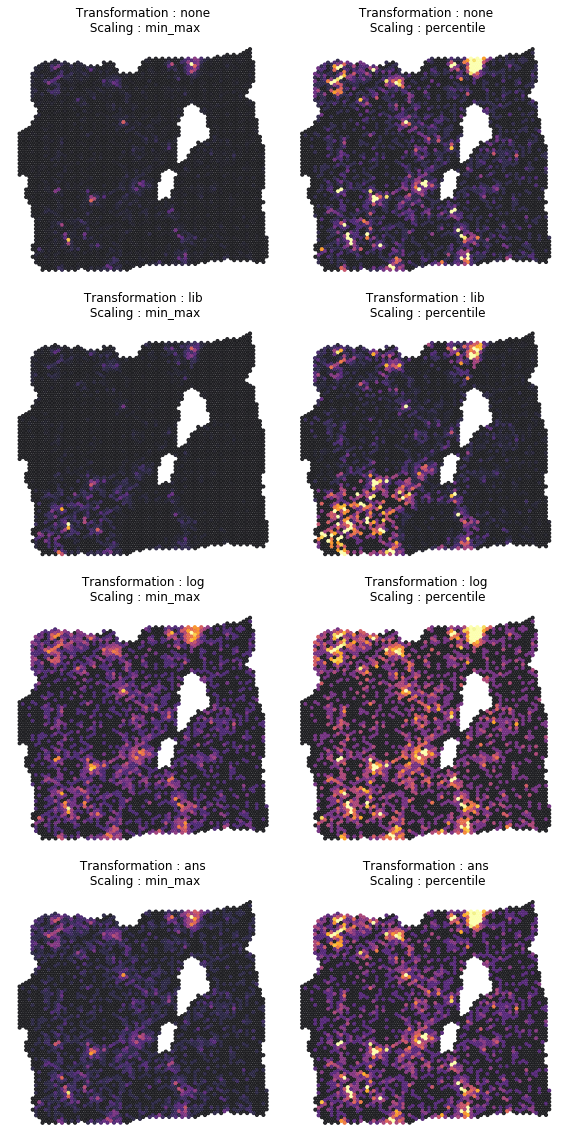

In [92]:
#------NON-CONCEPTUAL------#

ex_name = "CCL19"
ex_vals = data.X[:,np.argmax(data\
                             .var['name'] == ex_name)]

libsize = data.X.sum(axis =1).flatten()

trans_funcs = dict(none = lambda x: x,
                   lib = lambda x : np.divide(x,
                                            libsize,
                                            where = libsize > 0),
                   log = lambda x : np.log2(x + 1),
                   ans = lambda x : 2*np.sqrt(x + 3.0/8.0),
                    )

scale_funcs = dict(min_max = lambda x : (x - x.min()) /\
                                        (x.max() - x.min()),
                   percentile = lambda x : np.clip(x,
                                                   x.min(),
                                                   np.percentile(x,99)),
                   )

n_trans = len(trans_funcs)
n_scale = len(scale_funcs)

fig,ax = plt.subplots(n_trans,
                      n_scale,
                      figsize = (n_scale*4,n_trans*4))

axiter = iter(ax.flatten())

for tname,tfun in trans_funcs.items():
    for sname,sfun in scale_funcs.items():
        vals = sfun(tfun(ex_vals))
        plot_data(next(axiter),
                  data,
                  plt_args = {"cmap":plt.cm.inferno,
                              "s":10,
                              "c":vals},
                  title = " Transformation : {} \n Scaling : {}".format(tname,sname),
                  show_image = False,
                  clean = True)
        
fig.tight_layout()
plt.show()

I hope that this allows you to appreciate how simple modifications, like whether you apply a log-transformation or not, can have a large impact on the final representation of your data. 

As mentioned above, it is fairly common to inspect the results from any analysis, supervised as well as unsupervised, by visualizing the expression of genes or features identified as relevant. If the results do not resonate with your expectations, it might be due to a suboptimal visualization approach and not poor quality of the analysis. Likewise, make sure the conclusions you make are not just a consequence of the means by which you represent the data.

## Basic Analysis

In this section we will have a look at some basic analysis that one may apply to our spaital data. First we'll cluster the data with respect to gene expression and then proceed to see what genes that may be associated with our clusters.


As we are only working with one sample, we do not really have to address "batch effects" here - but in general this is something you always should be aware and control for. 

### Clustering

As mentioned above we will cluster the data, however subjecting the complete raw expression data to any clustering algorithm is not to prefer, the reason being - as you likely have heard multiple times before - _the curse of dimensionality_. There are multiple interpretations of this statement, but it can more or less be summarized as _"in high dimensional space, everything is far away"_, meaning that algorithms relying on the notion of distance (especially euclidean) tend to break down in high dimensions. Thus, to circumvent this problem we:

1. Normalize the data
2. Project the data to a lower dimensional space (Using PCA)
3. Embed the projected data within a 2-dimensional manifold (Using UMAP)


We normalize the data to account for fluctuations in cell density and capture efficiency among our spots. PCA is applied before UMAP partially for computational reasons but also to remove noisy signals which might disrupt the manifold characterization by UMAP. Once mapped to the low dimensional manifold, the data is more apt for clustering, and we fit will cluster it using a GMM (Gaussian Mixture Model).

GMMs are mixture models that to some extent could be considered as a generalization of the _Kmeans_ clustering algorithm; you specify the number of components (multivariate Gaussian distributions) that you believe are present in your data, these are then learned from the data, and each observation (spot) is assigned a weight indicating the contribution of each component to that spot. We can obtain "hard labels" by assigning each spot to the component with highest contribution to said spot.   



In [93]:
# We normalize our data by first performing the aforementioned
# Anscombe transformation and then dividing by "library size"
# the transformed values by the total sum of all values
# within each spot, similar to library size
# normalization.


def normalize(X : np.ndarray,
                  )->np.ndarray:
    
    Y = 2*np.sqrt(X + 3./8.)
    Y /= Y.sum(axis=1,
               keepdims = True)
    return Y

In [94]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans as km
from sklearn.decomposition import PCA
import umap

# set a random seed for reproducibility
np.random.seed(1337)

# normalize the expression data
y = normalize(data.X)
# specify number of principal components to use in PCA, feel free to change!
pca_components = 20
# run PCA
y = PCA(n_components = pca_components).fit_transform(y)
# run UMAP
y = umap.UMAP(n_components = 2,
              random_state = 7,
             ).fit_transform(y)
# specify the number of components in the GMM, feel free to change!
gmm_components  = 7
# fit GMM to the data
fitted_gmm = GMM(n_components = gmm_components,
                 random_state = 7,
                ).fit(y)
# get component weights for each spot, "soft labels"
labels_soft = fitted_gmm.predict_proba(y)
# get hard labels for each spot
labels_hard = np.argmax(labels_soft,
                        axis = 1)


When the pre-processing and clustering is done, the results can be visualized in UMAP space as well as in the real spatial domain. Our `plot_data` function comes in handy again, this time we use it to color each spot w.r.t. its cluster identity. 

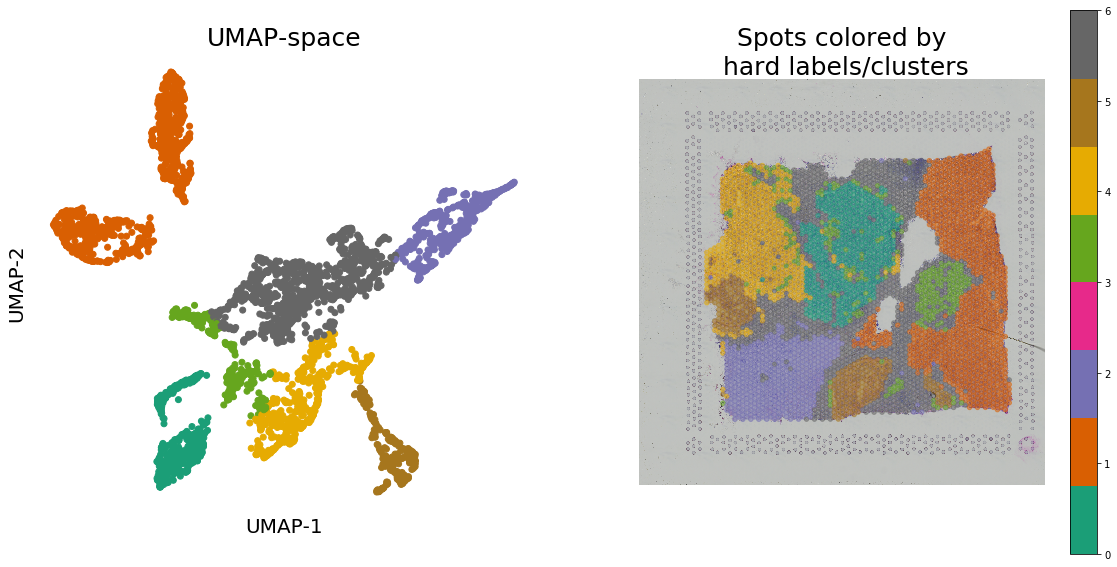

In [95]:
# create figure to plot result in UMAP and spatial space
fig,ax = plt.subplots(nrows = 1,
                      ncols = 2,
                      figsize = (20,10))

# plot embedded data, color by hard labels
sc = ax[0].scatter(y[:,0],
           y[:,1],
           c = labels_hard,
           cmap = plt.cm.Dark2,
          )

ax[0].set_aspect("equal")
ax[0].set_title("UMAP-space",
                fontsize = 25)
ax[0].set_xlabel("UMAP-1",
                 fontsize = 20)
ax[0].set_ylabel("UMAP-2",
                 fontsize = 20)

clean_ax(ax[0])

# color spots by hard labels and overlay on tissue
plot_data(ax[1],
          data,
          plt_args = {"c":labels_hard,
                      "cmap":plt.cm.Dark2,
                      "alpha":0.5,
                     },
          clean = True,
         )
ax[1].set_title("Spots colored by\n hard labels/clusters",
                fontsize = 25)

fig.colorbar(sc)
plt.show()

### Differential Gene Expression Analysis

Naturally, after identifying our clusters, we'd like to know what drives the formation of them. Perhaps the most obvious question to ask is which genes that are associated to each cluster, which can be answered by a standard DE-analysis. Many of the methods designed to for DE analysis relies on GLMs (generalized linear models) with the probability function being the negative binomial, this allows certain confounding factors to be accounted for - but can be quite inefficient when applied to large sample sizes such as in spatial data (each spot would be considered a sample), and similar results can usually be obtained with relatively basic methods.

Thus we will implement our own, very simple, DGE analysis (the function `dge_test`). In short, we design the function such that it allows us find which genes that are associated with a (by us) specified cluster. To find these genes, we first normalize the gene expression by library size, then for each gene we compare the expression values within the selected cluster to the rest of the clusters. This comparison entails a [Mann-Whitney U-test][1] (also known as Wilcoxon rank-sum test), where the null hypothesis could be interpreted as assuming that expression values from the two groups (selected cluster and the rest) originate from the same population. In other words; a low p-value should be interpreted as if the expression of the gene differs significantly between the selected cluster and the rest of the tissue.

One drawback with this approach is that we lump all non-selected clusters into a "megagroup", meaning that the genes we identify might not be characteristic only of the selected cluster; this is a fairly prevalent issue when working with non-binary fetaures (such as cluster index).

[1]: https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test

In [39]:
from scipy.stats import mannwhitneyu as utest
from statsmodels.stats.multitest import multipletests


def dge_test(data : ad.AnnData,
             labels : np.ndarray,
             contrast : Union[str,int],
             alpha : float = 0.01,
             positive : bool = True,
            )-> pd.DataFrame:
    
    """ conduct dge test
    
    Parameters:
    -----------
    
    data : ad.AnnData
        anndata object containing spatial data
    labels : np.ndarray
        labels indicating which group each observation
        belongs to. E.g., cluster indices.
    contrast : Union[str,int]
        label to be compared to the rest. Must
        be a member of "labels"
    alpha : float
        family-wise error rate (FWER) used for
        correction of MHT
    positive : bool
        only return genes with a positive log
        fold change. 
    
    Returns:
    --------
    Pandas data frame with 4 columns:
    pval, contains unadjusted p-values from
    the U test; pval_adj contains the adjusted
    p-values; l2fc, the log2FoldChange values,
    when comparing the mean of the selected
    group toward the rest; sig, inidcator
    of whether the gene has a significant
    p-values (1) or not (0). Genes are
    sorted w.r.t significance.
    
    
    """
    
    # object to hold result values
    res = np.zeros((data.X.shape[1],4))
    res[:,0] = np.nan
    res = pd.DataFrame(res,
                       index = data\
                               .var["name"]\
                               .values,
                       columns = ['pval',
                                  "pval_adj",
                                  "l2fc",
                                  "sig"],
                      )
    
    
    # library size normalization 
    libsize = data.X.sum(axis =1,
                         keepdims = True)
    
    norm_data = data.X / libsize
    
    # get indices for group members
    pos_1 = labels == contrast
    pos_2 = labels != contrast
     
    # test every gene
    for g in range(data.X.shape[0]):
        # skip if gene is not observed in any spot
        if norm_data[:,g].sum() <= 0:
            res.iloc[g,0] = np.nan
        else:
            # perform U test
            _,pval = utest(norm_data[pos_1,g],
                           norm_data[pos_2,g])
            # store p-value
            res.iloc[g,0] = pval 

            # compute average expression for
            # selected cluster and rest
            mu_1 = np.mean(norm_data[pos_1,g])
            mu_2 = np.mean(norm_data[pos_2,g])

            # compute log2FoldChange
            if mu_1 == 0: 
                l2fc = -np.inf
            elif mu_2 == 0:
                l2fc = np.inf
            else:
                l2fc = np.log2(mu_1) - np.log2(mu_2)
            
            # sotre l2FC
            res.iloc[g,2] = l2fc
    
    # remove bad genes
    res = res.dropna()
    # correct fot MHT, adjust p-values
    mht = multipletests(pvals = res["pval"].values,
                                method = "fdr_bh",
                                alpha = alpha)
    
    # store adjusted p-values
    res.loc[:,"pval_adj"] = mht[1]
    # add indicator of significane
    res.loc[:,"sig"] = (res["pval_adj"]\
                        .values <= alpha)\
                        .astype(int)
    # sort values
    res = res.sort_values(by = "pval_adj",
                          axis = 0)
    
    # remove negative l2FC values
    # if specified
    if positive:
        res = res.\
              iloc[res["l2fc"]\
              .values > 0,:]
    
    return res

Now, let us conduct a DGE analysis by using this function . I've selected cluster $5$ as the "cluster of interest" to contrast against the remaining clusters, but you may of course change this. It might be interesting to see how the sets of associated genes differ between clusters.

In [96]:
cluster_of_interest = 5
dge_res = dge_test(data,
                   labels = labels_hard,
                   contrast = cluster_of_interest,
                   positive=True)

Next, we will visualize the $20$ genes with lowest adjusted p-value (most significant). You can see how the expression of some genes is more or less confined to a region overlapping with the selected cluster, while others are more spread out.

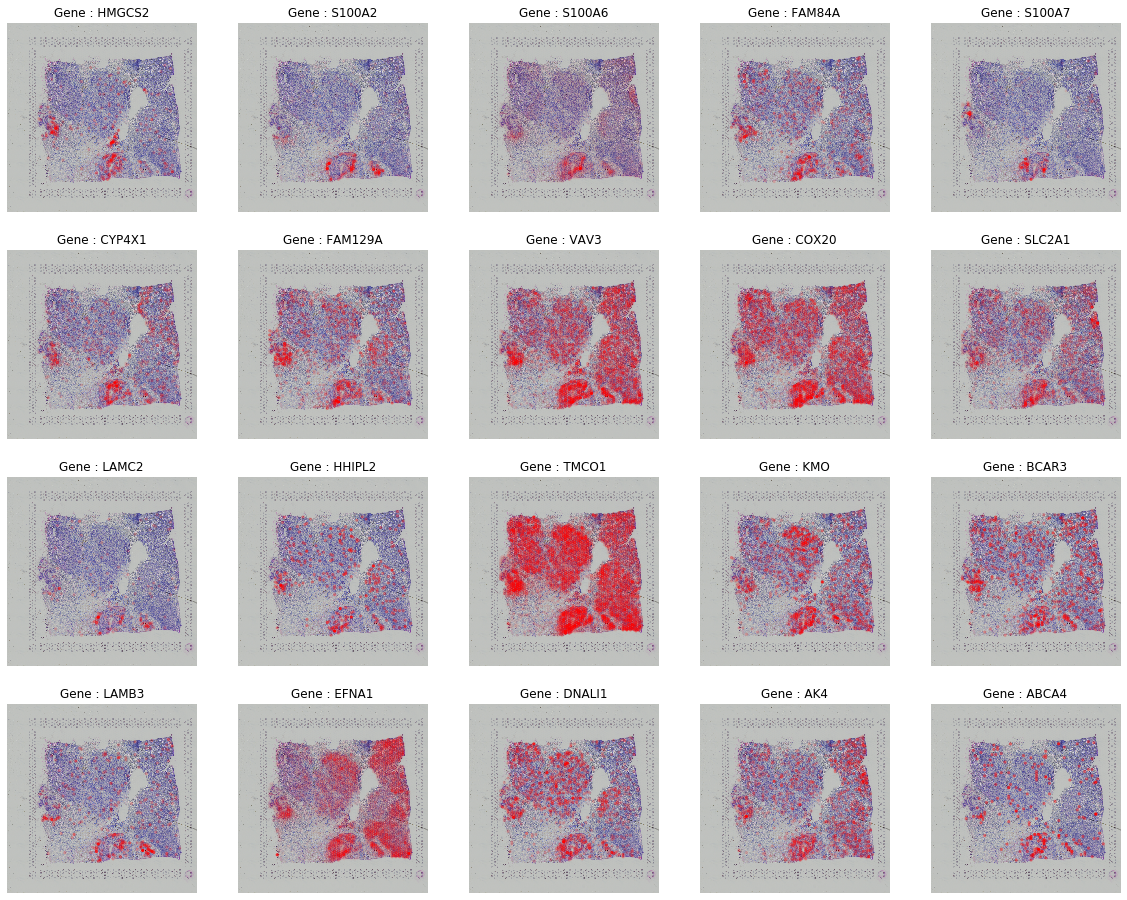

In [97]:
#------NON-CONCEPTUAL------#

fig,ax = plt.subplots(4,
                      5,
                      figsize = (20,16))
ax = ax.flatten()

for _ax,gene in zip(ax,dge_res.index.values[0:20]):
    
    plot_data(_ax,
              data,
              feature = ["name",gene],
              plt_args = {"cmap":"feature",
                          "s":5},
              title = "Gene : {}".format(gene),
             )

We can compare this to simply extracting the top $20$ highest expresed genes within the selected cluster, and what we observe is that - in general - these are even more unspecific to our cluster of interest.

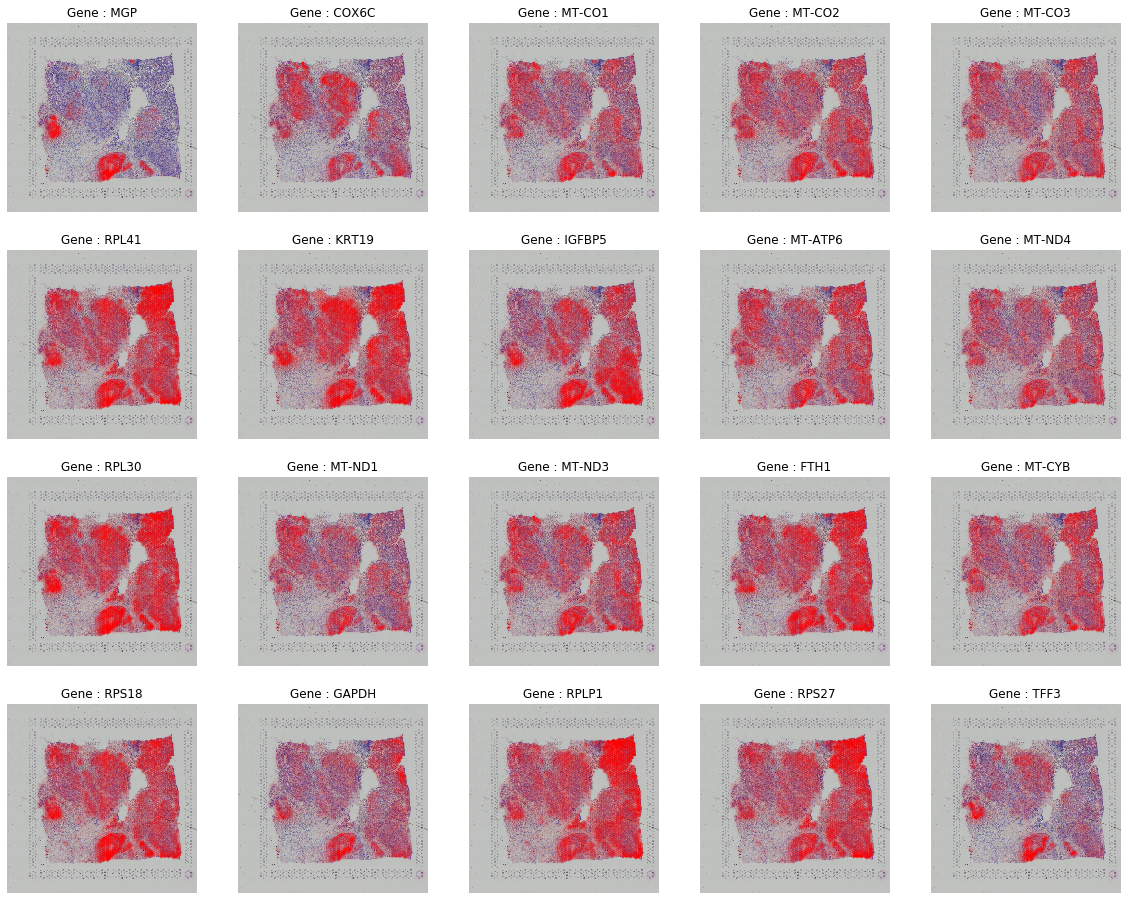

In [98]:
#------NON-CONCEPTUAL------#

fig,ax = plt.subplots(4,5,
                      figsize = (20,16))
ax = ax.flatten()

Y = data.X / data.X.sum(axis = 1,
                        keepdims=True)
topexpr = data.var["name"]\
              .values[np.argsort(Y[labels_hard == cluster_of_interest ,:]\
              .sum(axis = 0))[::-1][0:20]]

for _ax,gene in zip(ax,topexpr):
    
    plot_data(_ax,
              data,
              feature = ["name",gene],
              plt_args = {"cmap":"feature",
                          "s":5},
              title = "Gene : {}".format(gene),
             )

Feel more than free to change and play around with the `dge_test` function; try modifying it and see what happens. One  adjustment that you could try to implement is to make the function compare the selected cluster to each of the other clusters - one by one - and _then_ grab the highest p-value as the metric of significance. Maybe this could allow us to extract even cluster-specific genes?

We can, just as with single cell and bulk data, generate a volcano plot in order to visually summarize the result from our DE analysis. We will examplify this using the same cluster of interest as above. Since the DE analysis runs relatively fast, we rerun it but this time _keep_ all genes and not only those with a positive fold change.

In [99]:
dge_res_2 = dge_test(data,
                     labels = labels_hard,
                     contrast = cluster_of_interest,
                     positive=False,
                    )

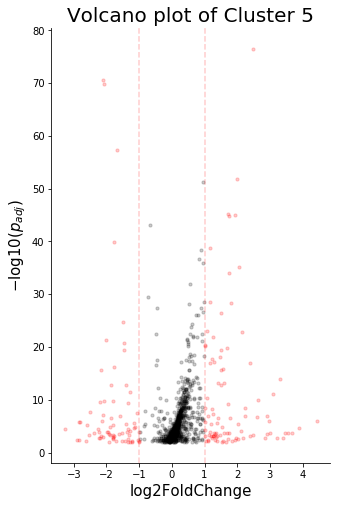

In [100]:
#------NON-CONCEPTUAL------#

# only include select genes with 
# significant adjusted pvalues
dge_res_2 = dge_res_2\
            .iloc[dge_res_2['sig']\
            .values == 1,:]

# create plot objects
fig,ax = plt.subplots(nrows=1,
                      ncols=1,
                      figsize = (5,8))

# get indices of genes with a |l2FC| >= 1
sel_above = (np.abs(dge_res_2["l2fc"].values) >= 1) *\
            (dge_res_2["pval_adj"].values <= 0.01)

# get indices of genes with a |l2FC| < 1
sel_below = (sel_above == False)

# plot pval against l2FC
for idx, color in zip([sel_below,sel_above],
                     ["black","red"]):
    
    ax.scatter(dge_res_2['l2fc']\
               .values[idx],
               -np.log10(dge_res_2['pval_adj']\
                         .values[idx] + 1e-237),
               s = 10,
               alpha = 0.2,
               c = color,
              )

# add vertical lines for l2fc cutoff
for x in [1,-1] : ax.axvline(x = x,
                             alpha = 0.2,
                             linestyle = "dashed",
                             color = 'red')


# remove right and top spines
clean_ax(ax,
         remove_spines=["right",
                        "top"],
         keep_ticks = True)

# set labels and title of plot
ax.set_xlabel("log2FoldChange",fontsize = 15)
ax.set_ylabel(r"$-\log10(p_{adj})$",fontsize = 15)
ax.set_title("Volcano plot of Cluster {}"\
             .format(cluster_of_interest),
            fontsize = 20)
plt.show()

## Factor analysis

The analysis we've conducted so far has focused on assigning each spot to one cluster, this is nevertheless somewhat contradictory to the nature of our data. As pointed out during the lectures, several cells usually reside at each spot meaning that multiple cell types or cells in different states may be present at said location. As a consequence, the gene expression we observe at each spot is a **mixture** of contributions from different entities. Our expression-based clusters therefore do not necessarily have a bijective relationship to cell types or states - the clusters are more like an assembly of spots with similar expression profiles. 

Clustering of our data can inform us of which spots that are similar w.r.t. to their gene expression, but keeping in mind how each spot's expression profile is a mixture, it might be more interesting to know what the constituents of these mixtures are and how they are distributed within the data. It's as if we have been presented with a buffé and now are ask for the ingredients of every dish.

To approach this question, we can consider each spot as a combination of some latent - unobserved - factors. These factors, depending on how we design them, could represent transcription programs or alternatively cell types. In contrast to a spot being assigned to a single cluster, it is defined by the composition of different contributions from respective factor. The process of retrieving and characterizing these factors, might be referred to as a form of _decomposition_ or _factorization_. The factors can be learned from the data, but also defined _a priori_; a good example of the latter is when single cell data is integrated with spatial data (Part 2) - then the latent factors are the cell types. However, for now we will focus on the case when we do not know the character of our factors _a priori_ to the analysis.

There is a plethora of different methods to conduct factor analysis or modelling of similar problems, some of them designed specifically with gene expression data in mind (e.g., [STD][1]). Since more complex models tends to take longer time to fit and converge, we will use a relatively simple form of factorization called [Latent Dirichlet Allocation][2] (LDA) - borrowed from the field of [topic modelling][3]. 

I will elaborate more regarding LDA below, but before proceeding, we will add a small update to our `filter_features` function. The way we wrote `filter_features` was to filter genes with less than a certain number of total UMI's and/or observed in fewer than a given number of spots. But, as we saw when we looked at the highly variable genes and the top expressed genes in our clusters - mitochondrial (_MT-\*_) and ribosomal (_RP\*_) genes have a tendency to show up in our results even though we might not be that interested in them, therefore we will add $2$ options to the filtering; the choice to remove either or both of (1) ribosomal genes and (2) mitochondrial genes.


[1]: [https://doi.org/10.1101/362624]
[2]: [http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf]
[3]: [https://en.wikipedia.org/wiki/Topic_model]

In [45]:
from functools import reduce
import re

def filter_features(data : ad.AnnData,
                    min_obs : float = 0.01,
                    min_tot : float = 100,
                    ribo_filter : bool = False,
                    mito_filter : bool = False,
                    verbose : bool = True,
                   ) -> np.ndarray:
    
    """filter features
    
    Parameters:
    ----------
    
    data : ad.AnnData
        anndata object containing spatial data
    min_obs : float
        minimal fraction or number of spots that
        gene should be observed at. If min_obs <1
        it will be intepreted as a fraction.
    min_tot : float
        minimal number of total UMI's
        for a gene
    ribo_filter: bool
        filter ribosomal genes
    mito_filter : bool
        filter mithocondrial genes
        
    Returns:
    -------
    
    boolean vector of indices to keep
    
    
    """
    
    
    # get dimensions
    n_spots, n_genes = data.X.shape
    
    # get number of spots that genes
    # should be observed at
    if min_obs < 1:
        adj_min_obs = min_obs*n_spots
    else:
        adj_min_obs = np.min((min_obs,
                              n_spots))
        
    
    # initiate list to store boolan
    # for respective criteria
    keep = list()
    
    # add boolean vectors w.r.t. 
    # min_tot and min_obs criteria 
    keep.append(data.X.sum(axis = 0) > min_tot)
    keep.append((data.X > 0).sum(axis=0) > adj_min_obs)
    
    # filter ribosomal genes
    if ribo_filter:
        rrp = lambda x: not bool(re.match("^(RP)",
                                      x.upper()))
        
        keep.append(np.array(list(map(rrp,
                                      data\
                                      .var["name"]\
                                      .values))))
    # filter mitochondrial genes
    if mito_filter:
        rmt = lambda x: not bool(re.match("^(MT)",
                                      x.upper()))
        
        keep.append(np.array(list(map(rmt,
                                      data\
                                      .var["name"]\
                                      .values))))
    
    
    # join all criteria
    keep = reduce((lambda x,y : x *y),keep)
    
    # if verbose, print information
    if verbose:
        print("Filtering Features with |"\
              " min_obs < {} spots |"\
              " min_tot < {} UMIs"\
              .format(adj_min_obs,min_tot))
        
        print("Kept {}/{} genes"\
              .format(keep.sum(),n_genes))

    return keep
    

We can now generate a new boolean vector to indicate which genes that should be included and excluded respectively in our analysis, using the updated filtering function.

**Note**: Don't forget to run the cell above, otherwise you will still be using the old filtering function.

In [46]:
keep_genes = filter_features(data,
                             min_obs= 0.01,
                             min_tot=100,
                             mito_filter = True,
                             ribo_filter = True,
                             )

Filtering Features with | min_obs < 38.13 spots | min_tot < 100 UMIs
Kept 14084/33514 genes


### LDA - Latent Dirichlet Allocation

LDA was first presented in 2003 (see reference above), the original problem it was designed to solve can be described as: <br>
<br>
_"Given a corpus of $M$ documents, with a vocabulary consisting of $V$ words, assume each document can be assigned to one or more of $T$ topics. Each topic $t$ is characterized by it's frequency distribution over the $V$ words. How are the words distributed across the topics and how are the topics distributed across the documents."_
<br><br>
If we consider this in the context of spatial transcriptomics, we can see how an alternative formulation could be stated as :
<br>
<br>
_"Given a section with $S$ spots, with a total of $G$ genes being expressed across all spots, assume each spot can be assigned to one or more of $P$ expression programs. Each program $p$ is characterized by it's frequency distribution over the $G$ genes. How are the genes distributed across the expression programs and how are the programs distributed across the spots."_
<br>
<br>
As always, one should be careful when applying a method designed for one problem to another. In LDA, certain assumptions regarding the data are made - and not all of them are necessarily true for gene expression data. However, as you will see, it can still provide informative results.<br>
<br>
We will be using the LDA implementation provided by [scikit-learn][1], it's not the fastest algorithm to run and depending on your computer's specs, it might take a while to complete the fitting. In this implementation, you need to specify the number of topics that you want to characterize, here it is set to 7. <br>
<br>
**Note**: If you don't feel like waiting, or are just keen on moving on fast, skip the next cell and instead execute the one after it. This will load the fitted model (saved as a pickle object), and allow you to continue with the follwing steps immediately.

[1]: [https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html]

In [47]:
# Execute this cell if you want to fit the LDA model
# to our data, skip if you prefer to just load the already
# fitted model

from sklearn.decomposition import LatentDirichletAllocation as LDA

n_topics = 7

lda_model = LDA(n_components= n_topics,
                learning_method = "online",
                random_state = 1337,
                ).fit(data.X[:,keep_genes])




KeyboardInterrupt: 

In [101]:
#------NON-CONCEPTUAL------#

# Execute this cell if you eant to load the fitted model
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pickle

with open('../data/lazy/lda.pickle', 'rb') as f:
    lda_model = pickle.loads(f.read())
    

In [78]:
# get topic probabilities for each spot
topic_proportions = lda_model.transform(data.X[:,keep_genes])

Let us now visualize how the topics are distributed across our spots. Here we will be plotting the topic proportions within each document, or using the terminology of our interpretation, the contribution of each expression program to respective spot. 

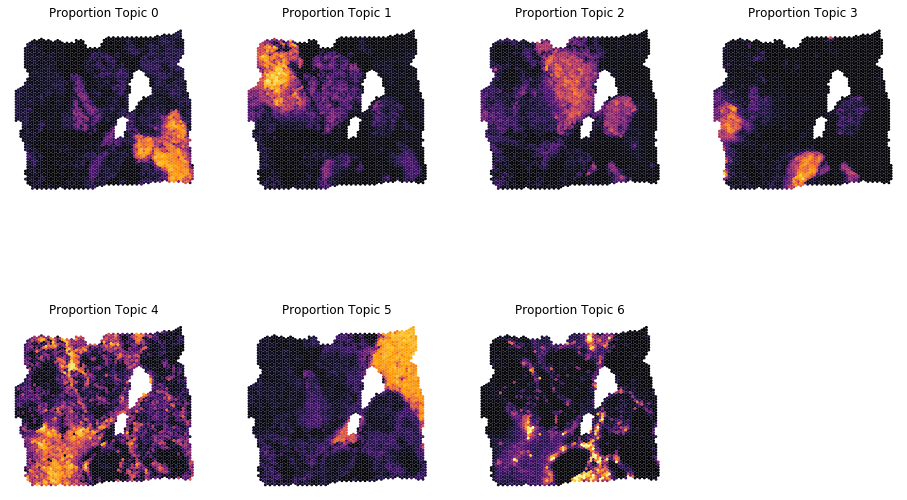

In [79]:
#------NON-CONCEPTUAL------#

# initiate plot object
fig, ax = plt.subplots(2,
                       4,
                       figsize = (16,10))
ax = ax.flatten()
# plot proportion of each expression program
for k in range(n_topics):
    vals = topic_proportions[:,k]
    plot_data(ax[k],
              data,
              plt_args = {"c":vals,
                          "cmap":plt.cm.inferno,
                          "s":4,
                          "marker":"H",
                          "alpha":1,
                           "vmin": 0,
                          "vmax": 1,
                         },
              title = "Proportion Topic {}".format(k),
              clean = True,
              show_image = False,
             )
    
for _k in range(k+1,ax.shape[0]):
    ax[_k].remove()
    

The spatial distribution of our topics have some resemblance with the clusters we generated before, this is expected since both approaches are driven by the gene expression. By design, LDA assigns each word (or gene) a _pseudocount_ within respective topic, which is indicative of how strongly associated the two (word and topic) are. This means that we do not have conduct any form of DE analysis in order to find genes representative of the topics/expression programs. To exemplify how this may be used in our analysis, we will inspect one topic more thoroughly. 

Topic/ Expression program 6 looks intriguing, with it's arrangement along the periferi of topic 3. We will first sort the genes w.r.t. pseudocount within this topic, and then - similar to when studying the variance - look at how the pseudocount values are distributed over the genes by considering them as a function of the rank.

**Note** : the fitted model (i.e., the object `lda_model`) have several attributes, which you can read more about on the page linked to above; the pseudocounts are accessed via `.components_`, this is a numpy array with the dimensions `n_topics x n_words`.

In [104]:
# specify topic of interest
topic_of_interest = 6
# extract pseudocount values in topic 6 for all genes
counts = lda_model.components_[topic_of_interest,:]
# get indices for the pseudocounts when sorted from high to low
count_srt = np.argsort(counts)[::-1]


To ensure that the genes we select "checks out" and exhibit a distribution that makes sense when related to the topic proportions visualized above, we will visualize the $10$ genes with highest pseudocount values. 

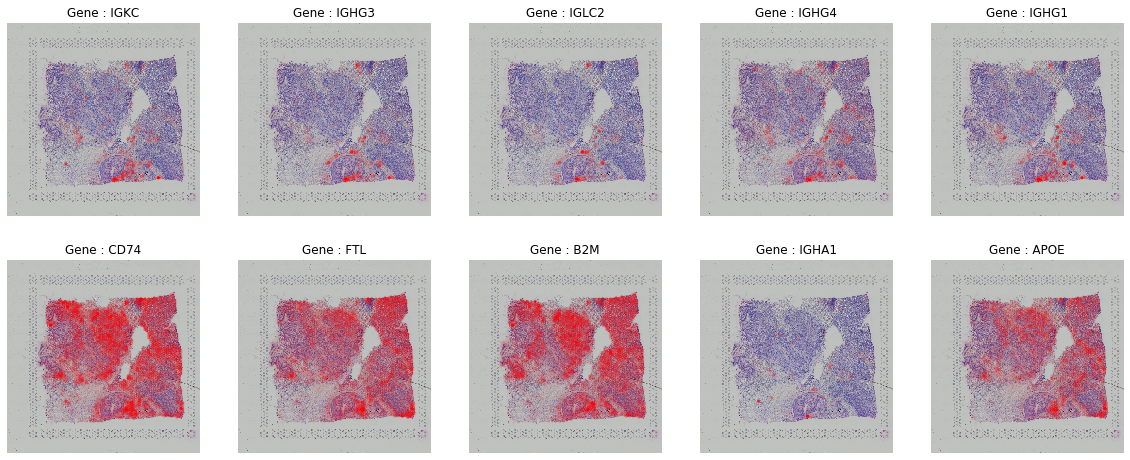

In [105]:
#------NON-CONCEPTUAL------#
names_srt = data.var["name"][keep_genes][count_srt]
names_top = names_srt[0:10]

fig,ax = plt.subplots(2,
                      5,
                      figsize = (20,8))
ax = ax.flatten()

for _ax,gene in zip(ax,names_top):
    
    plot_data(_ax,
              data,
              feature = ["name",gene],
              plt_args = {"cmap":"feature",
                          "s":5},
              title = "Gene : {}".format(gene),
             )

The distributions of these top $10$ genes are affirmative, all of them overlapping relatively well with the pattern of Topic 6. Having confirmed that the results seems legitimate, we can continue by generating the rank-plot mentioned above.

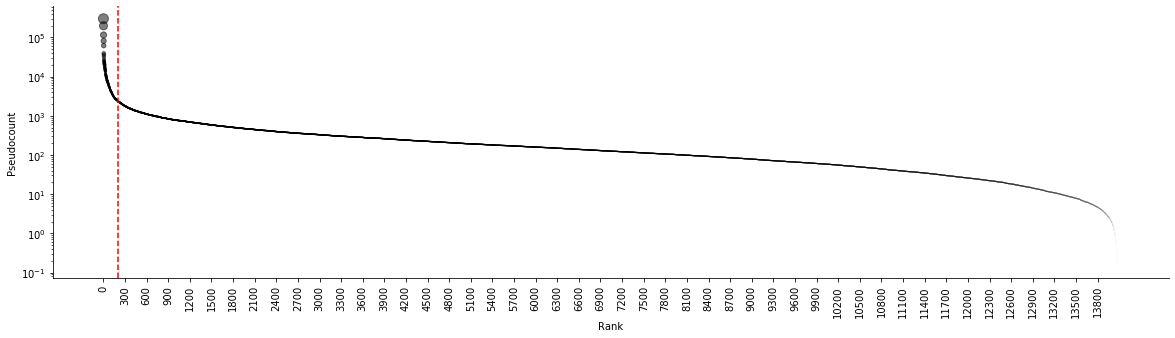

In [106]:
#------NON-CONCEPTUAL------#
fig,ax = plt.subplots(1,1, figsize = (20,5))

x_thrs = 200

ax.scatter(np.arange(counts.shape[0]),
          counts[count_srt],
          s = counts[count_srt] /\
              counts.max() *\
              100,
          color = "black",
          alpha = 0.5,
          )


x_ticks = np.arange(0,
                    counts.shape[0],300)\
                    .round(0)\
                    .astype(int)

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks,
                   rotation = 90)

ax.axvline(x = x_thrs,
           color = "red",
           linestyle = "dashed")


ax.set_yscale("log")
ax.set_xlabel("Rank",fontsize = 10)
ax.set_ylabel("Pseudocount",fontsize = 10)
clean_ax(ax,remove_spines=["right",
                           "top"],keep_ticks=True)
plt.show()

In the rank-plot, we can observe a sharp drop in the pseudocount values among the top $200$ genes, the curve then flattens to more of a gradual decrease. Similar to how a significance level can be used as a threshold in a DE analysis relying on hypothesis testing, we will use this charactersitic of our curve as a cutoff (red dashed line) to select genes strongly associated with the topic.

To annotate this factor, we subject the top $200$ genes to functional enrichment analsysis (FEA) using `g:Profiler`,  querying against the `GO:BP`database. You are welcome to use whatever enrichment tool you prefer, there is nothing "special" with `g:Profiler`  that makes it superior to other alternatives when working with spatial data; it simply has a nice API that I find easy to integrate in an analysis workflow like this.


In [107]:
from gprofiler import GProfiler

# instatiate gprogiler object that can be used for querying
gp = GProfiler(return_dataframe=True)
# query gene set using homo-sapiens as organism
enr_res = gp.profile(organism='hsapiens',
                     query=names_srt[0:x_thrs].tolist())



In [108]:
# select matches from the GO:BP 
enr_res = enr_res.iloc[enr_res["source"].values == "GO:BP",:]
display(enr_res.head(10))

source      native                                  name       p_value  \
6   GO:BP  GO:0002252               immune effector process  1.533079e-22   
8   GO:BP  GO:0006955                       immune response  4.370068e-22   
9   GO:BP  GO:0009605         response to external stimulus  1.859126e-20   
10  GO:BP  GO:0002376                 immune system process  5.908726e-20   
11  GO:BP  GO:0001775                       cell activation  1.963552e-19   
12  GO:BP  GO:0006950                    response to stress  2.107965e-19   
13  GO:BP  GO:0009607           response to biotic stimulus  3.620209e-19   
14  GO:BP  GO:0051707            response to other organism  6.881892e-19   
15  GO:BP  GO:0043207  response to external biotic stimulus  7.366607e-19   
16  GO:BP  GO:0010033         response to organic substance  8.118415e-19   

    significant                                        description  term_size  \
6          True  "Any process of the immune system that can pot...       1281   
8          True  "Any immune system process that functions in t...       2294   
9          True  "Any process that results in a change in state...       2923   
10         True  "Any process involved in the development or fu...       3235   
11         True  "A change in the morphology or behavior of a c...       1465   
12         True  "Any process that results in a change in state...       4147   
13         True  "Any process that results in a change in state...       1583   
14         True  "Any process that results in a change in state...       1551   
15         True  "Any process that results in a change in state...       1553   
16         True  "Any process that results in a change in state...       3421   

    query_size  intersection_size  effective_domain_size  precision    recall  \
6          186                 62                  17906   0.333333  0.048400   
8          186                 81                  17906   0.435484  0.035310   
9          186                 89                  17906   0.478495  0.030448   
10         186                 93                  17906   0.500000  0.028748   
11         186                 62                  17906   0.333333  0.042321   
12         186                105                  17906   0.564516  0.025320   
13         186                 64                  17906   0.344086  0.040430   
14         186                 63                  17906   0.338710  0.040619   
15         186                 63                  17906   0.338710  0.040567   
16         186                 94                  17906   0.505376  0.027477   

      query                   parents  
6   query_1              [GO:0002376]  
8   query_1  [GO:0002376, GO:0050896]  
9   query_1              [GO:0050896]  
10  query_1              [GO:0008150]  
11  query_1              [GO:0009987]  
12  query_1              [GO:0050896]  
13  query_1              [GO:0050896]  
14  query_1  [GO:0043207, GO:0051704]  
15  query_1  [GO:0009605, GO:0009607]  
16  query_1              [GO:0042221]

From these results, it seems as if we with some confidence can annotate Topic/Expression Program 6 as _immune related_. A continuation of this analysis could for example be to characterize Topic/Expression Program 3 which - as noted above - topic 6 tends to be spatially proximal to; maybe some synergies between these two entities exists?

## Wrapping up Part 1

Hopefully, you feel slightly more comfortable to work with the spatial data. As mentioned several times throughout this exercise, this part was intended as an introduction and we will soon move on to some more sophisticated analysis and exciting topics. In Part 2 we will be looking at integration of single cell data.


Before we proceed to Part 2, I've set aside time to answer questions that might have arisen when working thorough the material. However, if you completed Part 1 faster than the estimated time required, feel free to move on to Part 2.
